In [1]:
import sdm as sdmlib
import matplotlib.pyplot as plt
import time
from collections import defaultdict, OrderedDict
from IPython.display import clear_output
%matplotlib inline

In [43]:
class Timer(object):
    def __init__(self):
        self.stats = OrderedDict()
        self.current_stats = None
        
    def start(self, key, name):
        self.current_stats = {
            'name': name,
            't0_loops': [],
            't0': time.time(),
        }
        self.stats[key] = self.current_stats
        self.t0 = time.time()
        
    def measure_loop(self):
        self.current_stats['t0_loops'].append(time.time())
        
    def end(self):
        d = self.current_stats
        d['dt'] = time.time() - d['t0']
        if d['t0_loops']:
            d['number-of-loops'] = len(d['t0_loops'])
            d['loops-per-second'] = d['number-of-loops'] / d['dt']
            d['loops'] = []
            
            t0 = d['t0']
            for t1 in d['t0_loops']:
                d['loops'].append(t1-t0)
                t0 = t1
        d.pop('t0')
        d.pop('t0_loops')
        self.current_stats = None

# Part 1 - Compare scanners

In [3]:
def run_part1(bits, sample, radius, nlinear=1000, nthread=5000, nopencl=5000):
    address_space = sdmlib.AddressSpace.init_random(bits, sample)
    address_space.opencl_init();
    
    timer = Timer()

    print('Running linear scan...')
    timer.start('scan_linear', 'Linear scan')
    for i in range(nlinear):
        bs = sdmlib.Bitstring.init_random(bits)
        address_space.scan_linear2(bs, radius)
        timer.measure_loop()
    timer.end()

    timer.start('scan_thread', 'Thread scan')
    print('Running thread scan...')
    for i in range(nthread):
        bs = sdmlib.Bitstring.init_random(bits)
        address_space.scan_thread2(bs, radius)  
        timer.measure_loop()
    timer.end()
    
    timer.start('scan_opencl', 'OpenCL scan')
    print('Running OpenCL scan...')
    for i in range(nopencl):
        bs = sdmlib.Bitstring.init_random(bits)
        address_space.scan_opencl2(bs, radius)
        timer.measure_loop()
    timer.end()
    
    return timer

In [1]:
def results_part1(bits, timer):
    from IPython.display import display, Markdown
    v = [['', 'Loops', 'Total time', 'Scans per second', 'Time per scan (ms)']]
    v.append(['---', '---:', '---:', '---:', '---:'])
    for key in ['scan_linear', 'scan_thread', 'scan_opencl']:
        stats = timer.stats[key]
        v.append([
            stats['name'],
            stats['number-of-loops'],
            stats['dt'],
            stats['loops-per-second'],
            1000.0 / stats['loops-per-second'],
        ])
    txt = '\n'.join(['|'.join([str(x) for x in row]) for row in v])
    display(Markdown(txt))
    
    latex = '\\ \hfill\n'.join([' & '.join([str(x) for x in row]) for row in v])
    print latex

    plt.figure(figsize=(8, 6), dpi=300)
    plt.hist([1000*x for x in timer.stats['scan_linear']['loops']], bins='fd', density=True, alpha=0.9, label='Linear scan')
    plt.hist([1000*x for x in timer.stats['scan_thread']['loops']], bins='fd', density=True, alpha=0.9, label='Thread scan')
    plt.hist([1000*x for x in timer.stats['scan_opencl']['loops']], bins='fd', density=True, alpha=0.9, label='OpenCL scan')
    plt.legend()
    plt.title('Scan performance ($n={}$ bits)'.format(bits))
    plt.xlabel('Scan duration (ms)')
    plt.ylabel('Probability')

In [5]:
timer1000 = run_part1(1000, 1000000, 451)

Running linear scan...
Running thread scan...
Running OpenCL scan...


In [2]:
results_part1(1000, timer1000)

NameError: name 'timer1000' is not defined

In [7]:
timer256 = run_part1(256, 1000000, 103)

Running linear scan...
Running thread scan...
Running OpenCL scan...


In [3]:
results_part1(256, timer256)
plt.xlim(2.4, 7.5);

NameError: name 'timer256' is not defined

In [9]:
timer10k = run_part1(10000, 1000000, 4845, nlinear=100, nthread=500, nopencl=1000)

Running linear scan...
Running thread scan...
Running OpenCL scan...


|Loops|Total time|Scans per second|Time per scan (ms)
---|---:|---:|---:|---:
Linear scan|100|11.6388039589|8.59194813773|116.388039589
Thread scan|500|26.7823820114|18.6689891805|53.5647640228
OpenCL scan|1000|12.952370882|77.2059423798|12.952370882

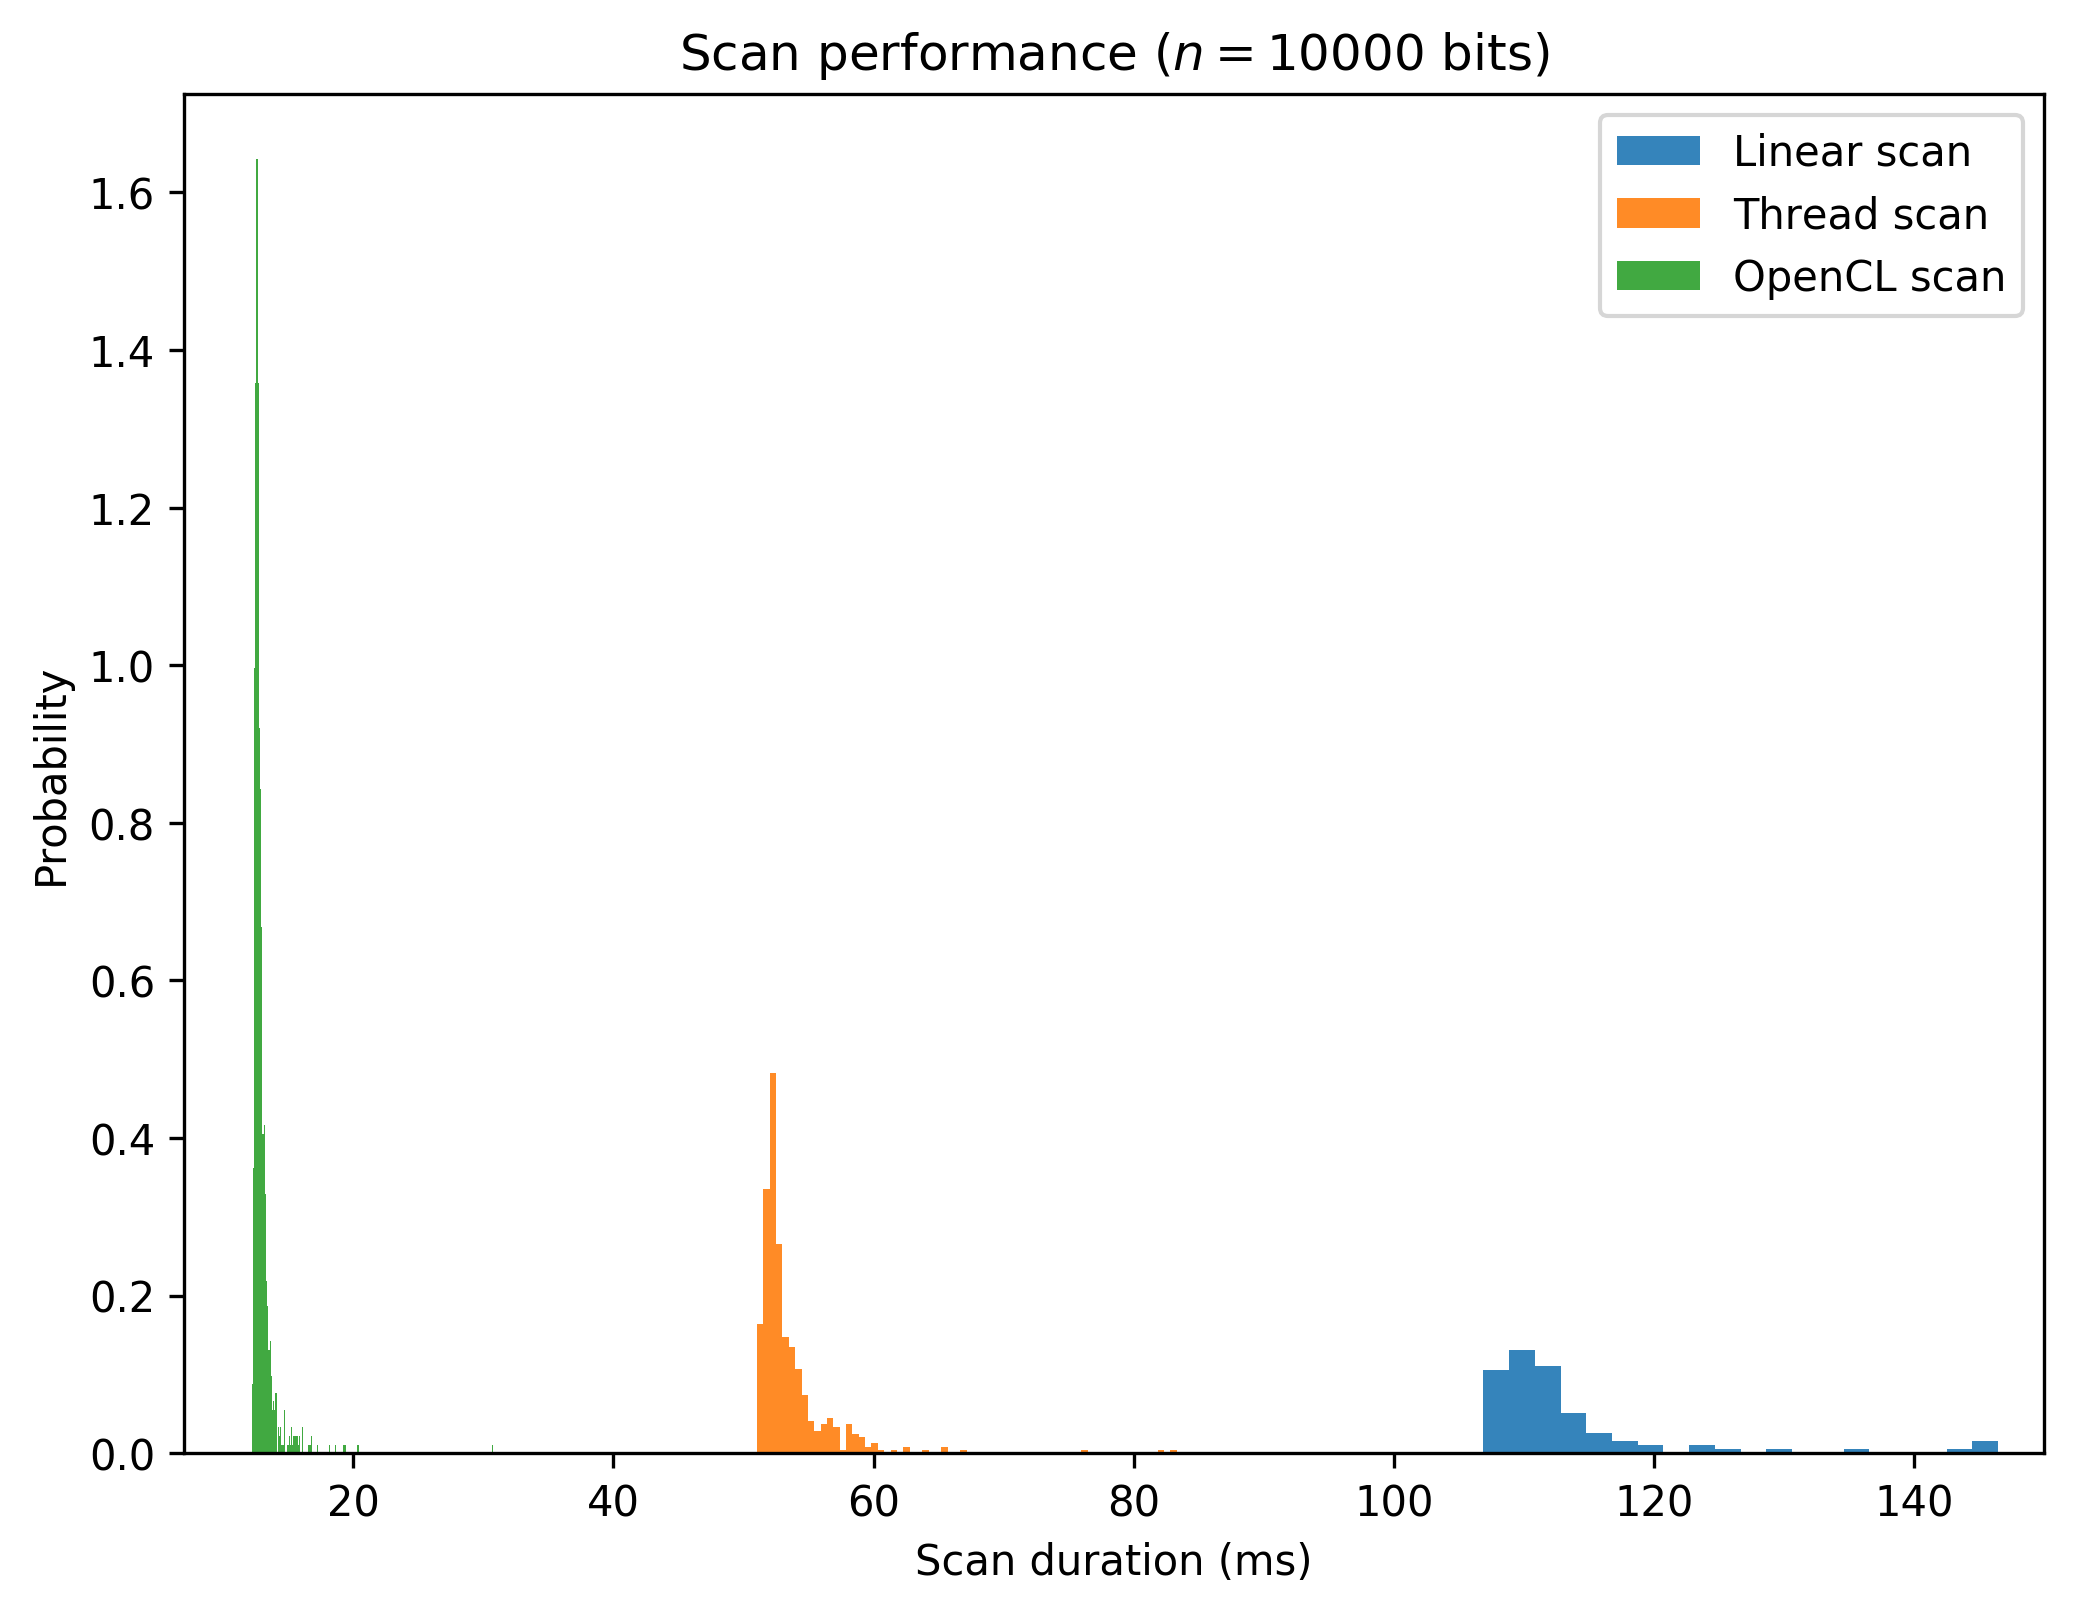

In [14]:
results_part1(10000, timer10k)
plt.xlim(7, 150);

# Part 2 - Compare scanners read/write

In [18]:
def read_write(key, name, timer, bits, sample, radius, scanner_type, n):
    address_space = sdmlib.AddressSpace.init_random(bits, sample)
    counter = sdmlib.Counter.init_zero(bits, sample)
    sdm = sdmlib.SDM(address_space, counter, radius, scanner_type)

    timer.start('write_{}'.format(key), '{} write'.format(name))
    for _ in range(n):
        bs = sdmlib.Bitstring.init_random(bits)
        sdm.write(bs, bs)
        timer.measure_loop()
    timer.end()
    
    timer.start('read_{}'.format(key), '{} single read'.format(name))
    for _ in range(n):
        bs = sdmlib.Bitstring.init_random(bits)
        sdm.read(bs)
        timer.measure_loop()
    timer.end()
    
    return timer

In [23]:
def run_part2(bits, sample, radius, nthread=1000, nopencl=1000):
    timer = Timer()
    print 'Running thread...'
    read_write('thread', 'Thread', timer, bits, sample, radius, sdmlib.SDM_SCANNER_THREAD, n=nthread)
    print 'Running OpenCL...'
    read_write('opencl', 'OpenCL', timer, bits, sample, radius, sdmlib.SDM_SCANNER_OPENCL, n=nopencl)
    return timer

In [65]:
def results_part2(bits, timer, hist_xlim=None):
    from IPython.display import display, Markdown
    v = [['', 'Loops', 'Total time', 'Operation per second', 'Time per operation (ms)']]
    v.append(['---', '---:', '---:', '---:', '---:'])
    for key in timer.stats.keys():
        stats = timer.stats[key]
        v.append([
            stats['name'],
            stats['number-of-loops'],
            stats['dt'],
            stats['loops-per-second'],
            1000.0 / stats['loops-per-second'],
        ])
    txt = '\n'.join(['|'.join([str(x) for x in row]) for row in v])
    display(Markdown(txt))

    plt.figure(figsize=(8, 6), dpi=300)
    for key in ['write_thread', 'write_opencl']:
        stats = timer.stats[key]
        plt.hist([1000*x for x in stats['loops']], bins='fd', density=True, alpha=0.9, label=stats['name'])
    plt.legend()
    plt.title('Write performance ($n={}$ bits)'.format(bits))
    plt.xlabel('Scan duration (ms)')
    plt.ylabel('Probability')
    if hist_xlim:
        plt.xlim(*hist_xlim)
    plt.show()
    
    plt.figure(figsize=(8, 6), dpi=300)
    for key in ['read_thread', 'read_opencl']:
        stats = timer.stats[key]
        plt.hist([1000*x for x in stats['loops']], bins='fd', density=True, alpha=0.9, label=stats['name'])
    plt.legend()
    plt.title('Read performance ($n={}$ bits)'.format(bits))
    plt.xlabel('Scan duration (ms)')
    plt.ylabel('Probability')
    if hist_xlim:
        plt.xlim(*hist_xlim)

In [40]:
p2timer1000 = run_part2(1000, 1000000, 451, nthread=1000, nopencl=1000)

Running thread...
Running OpenCL...


|Loops|Total time|Operation per second|Time per operation (ms)
---|---:|---:|---:|---:
Thread write|1000|13.3464519978|74.9262800457|13.3464519978
Thread single read|1000|10.3919007778|96.228786377|10.3919007778
OpenCL write|1000|7.90451812744|126.509925574|7.90451812744
OpenCL single read|1000|5.25757479668|190.201763869|5.25757479668

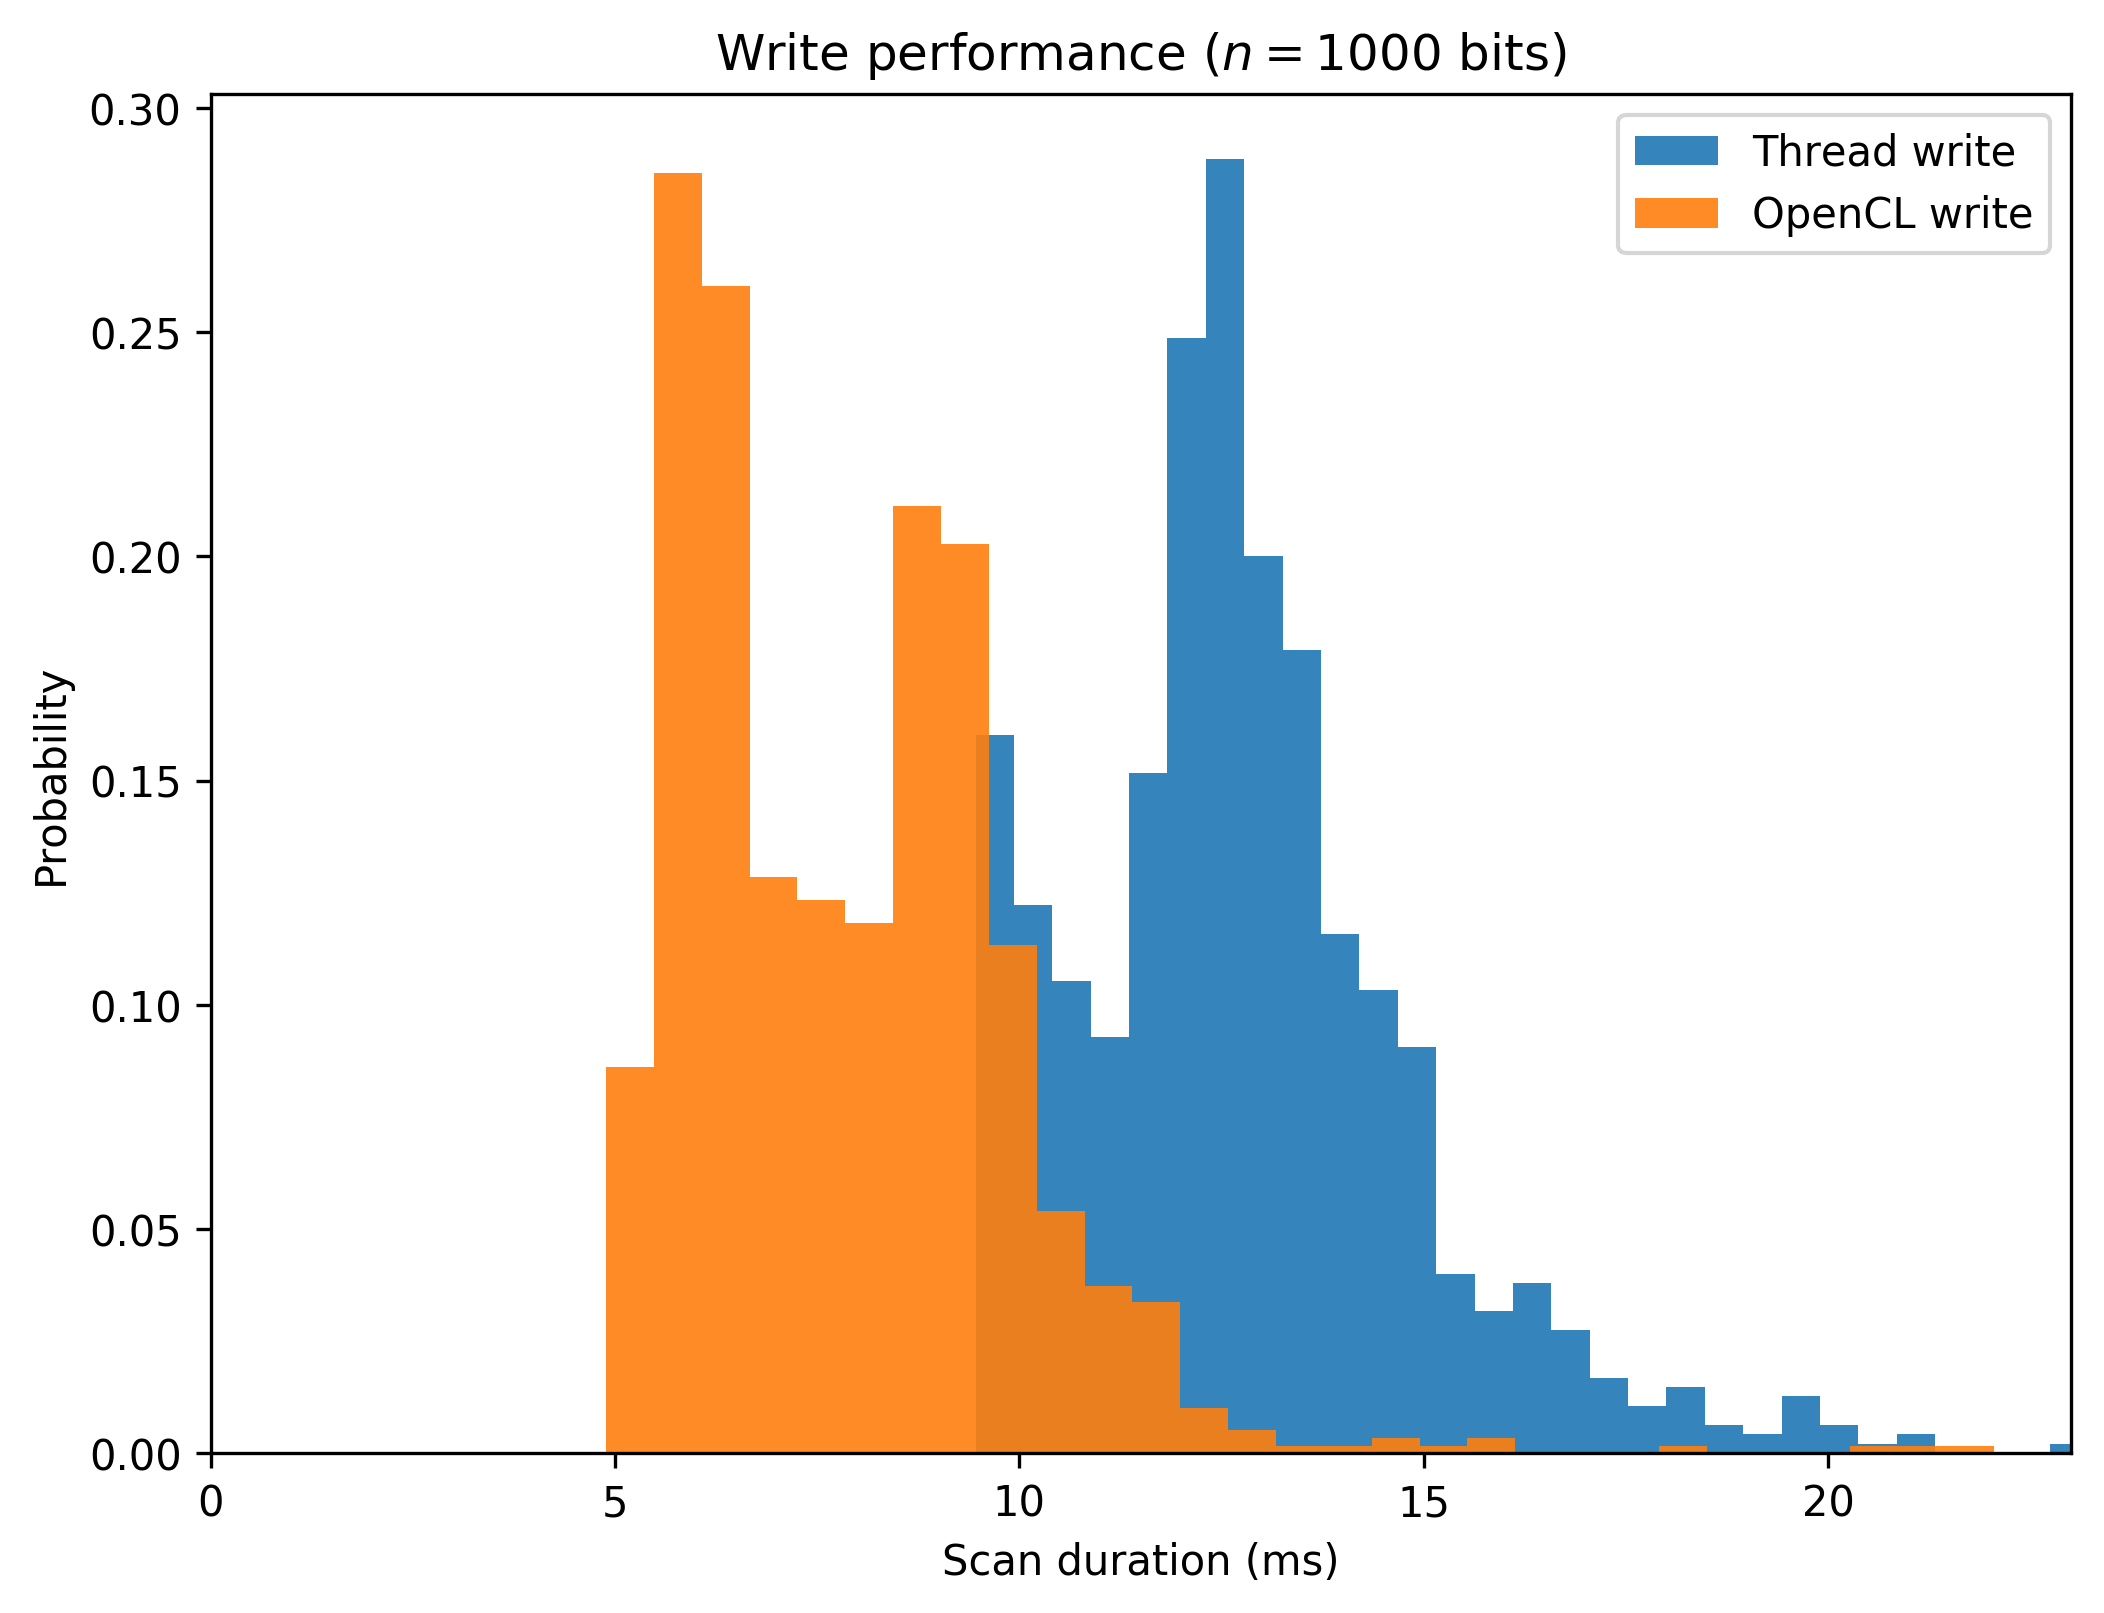

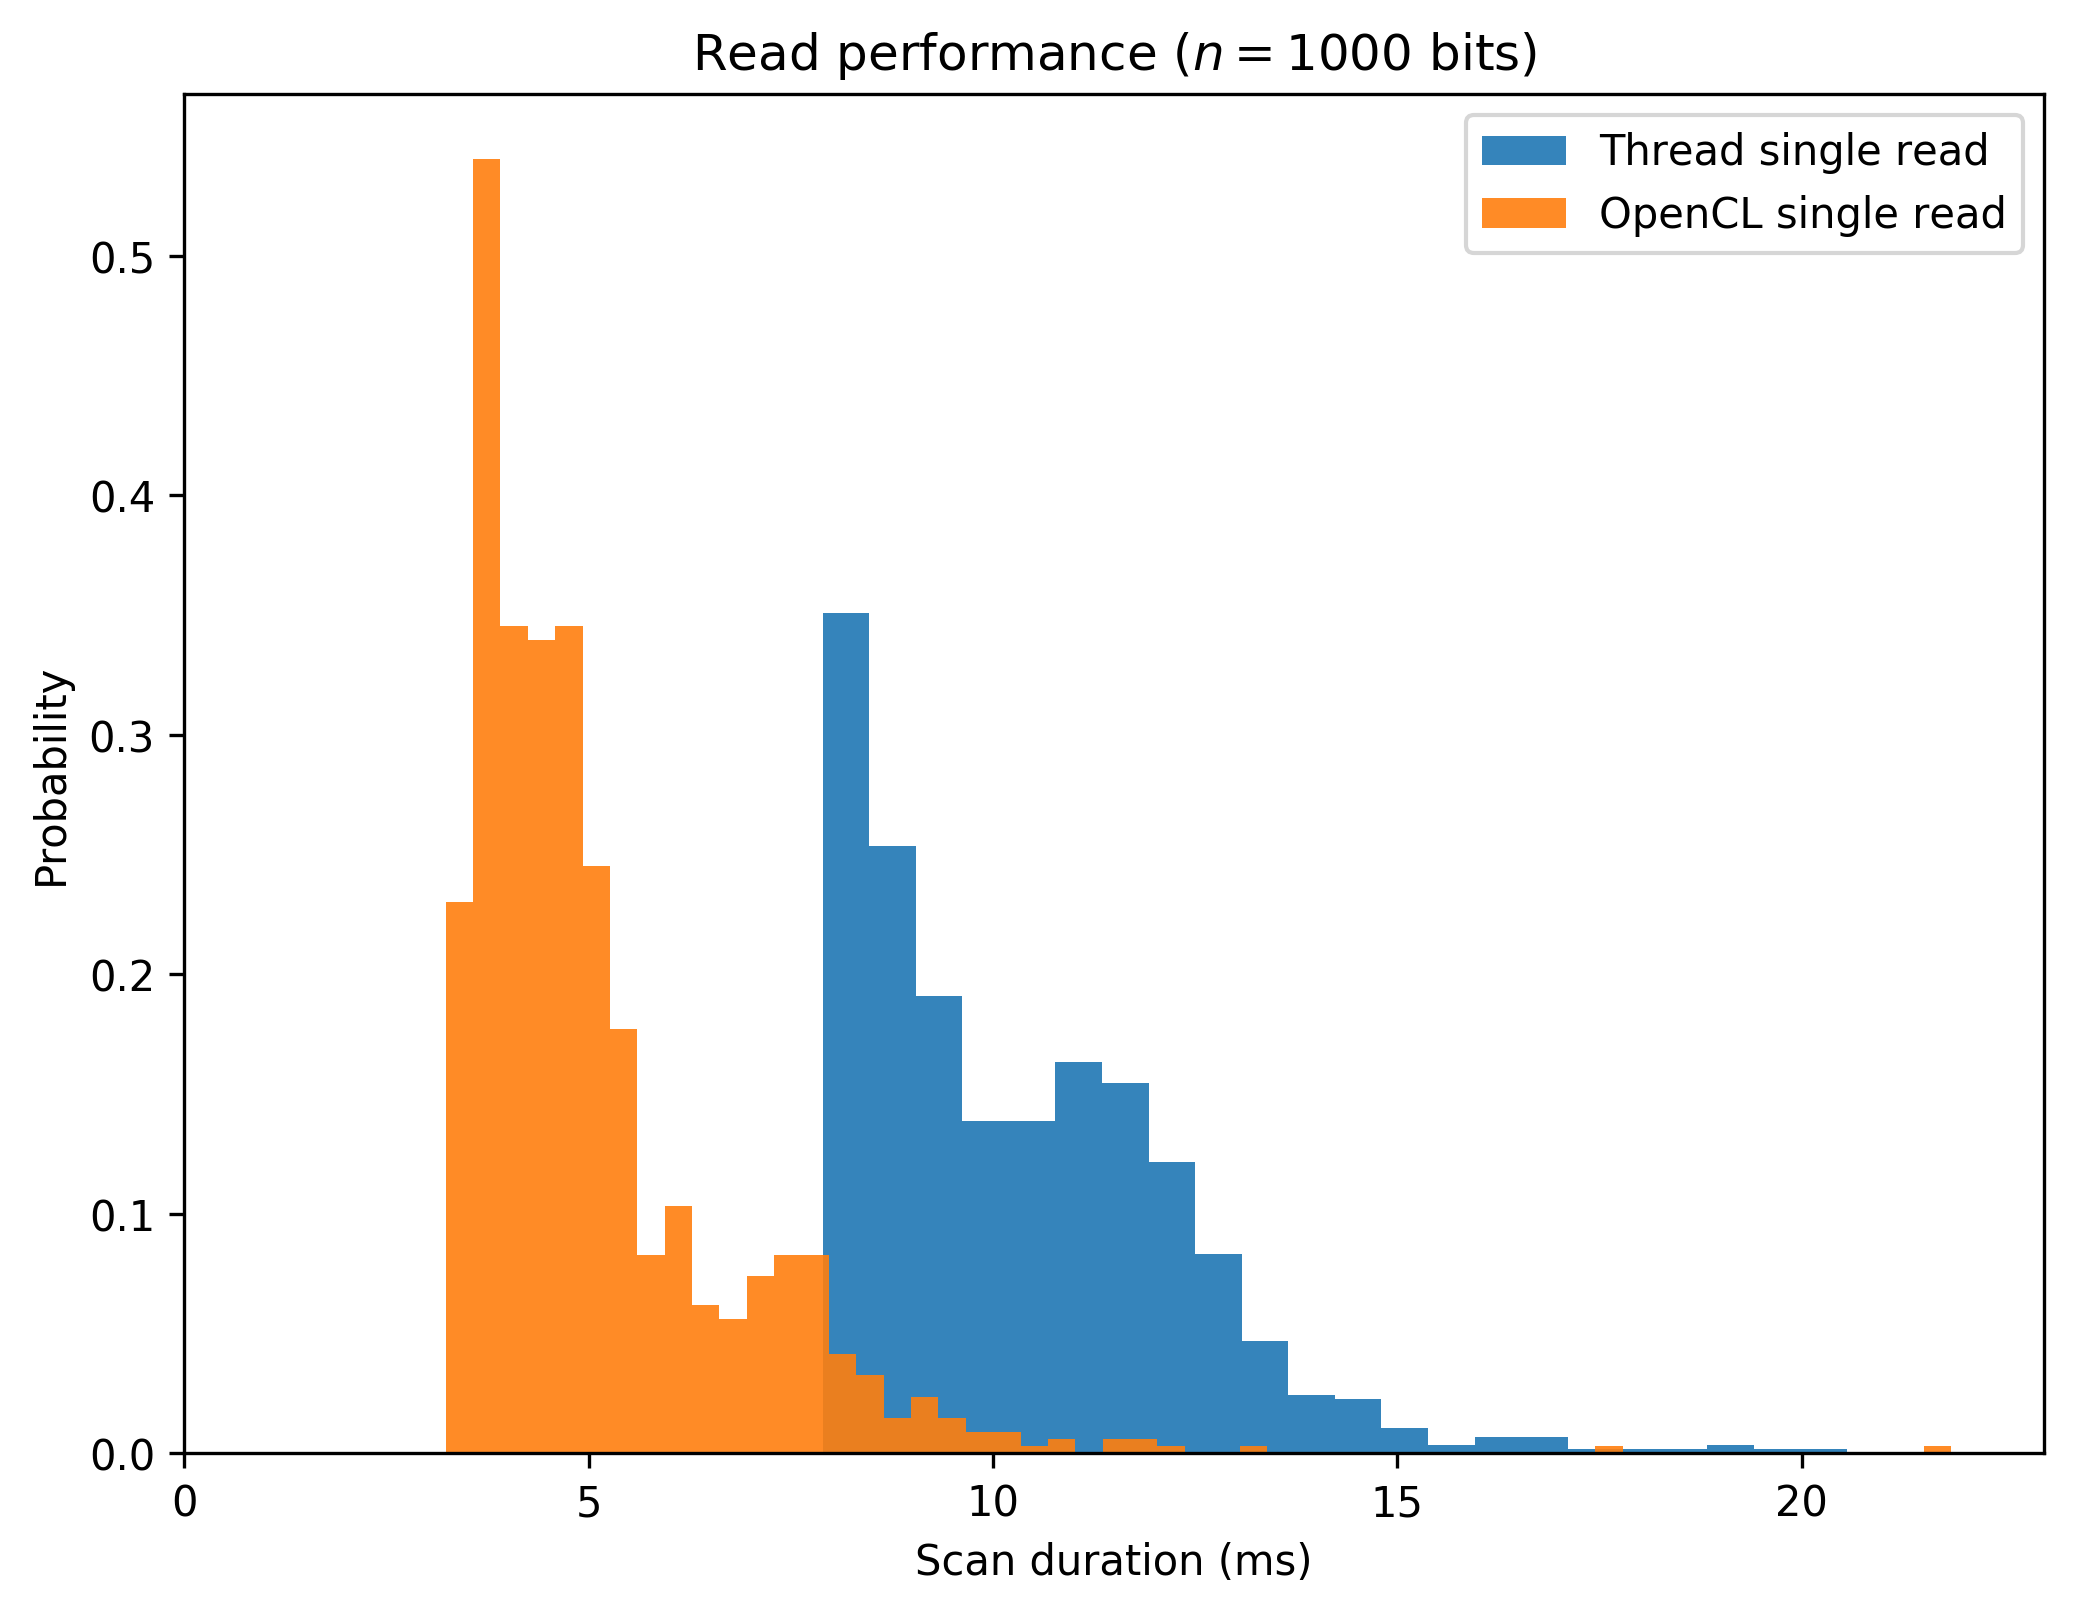

In [67]:
results_part2(1000, p2timer1000, hist_xlim=(0, 23))

In [53]:
p2timer256 = run_part2(256, 1000000, 103, nthread=2000, nopencl=2000)

Running thread...
Running OpenCL...


|Loops|Total time|Operation per second|Time per operation (ms)
---|---:|---:|---:|---:
Thread write|2000|6.56891107559|304.464465569|3.2844555378
Thread single read|2000|5.11222410202|391.219156298|2.55611205101
OpenCL write|2000|5.28474092484|378.448069346|2.64237046242
OpenCL single read|2000|4.29032301903|466.165365901|2.14516150951

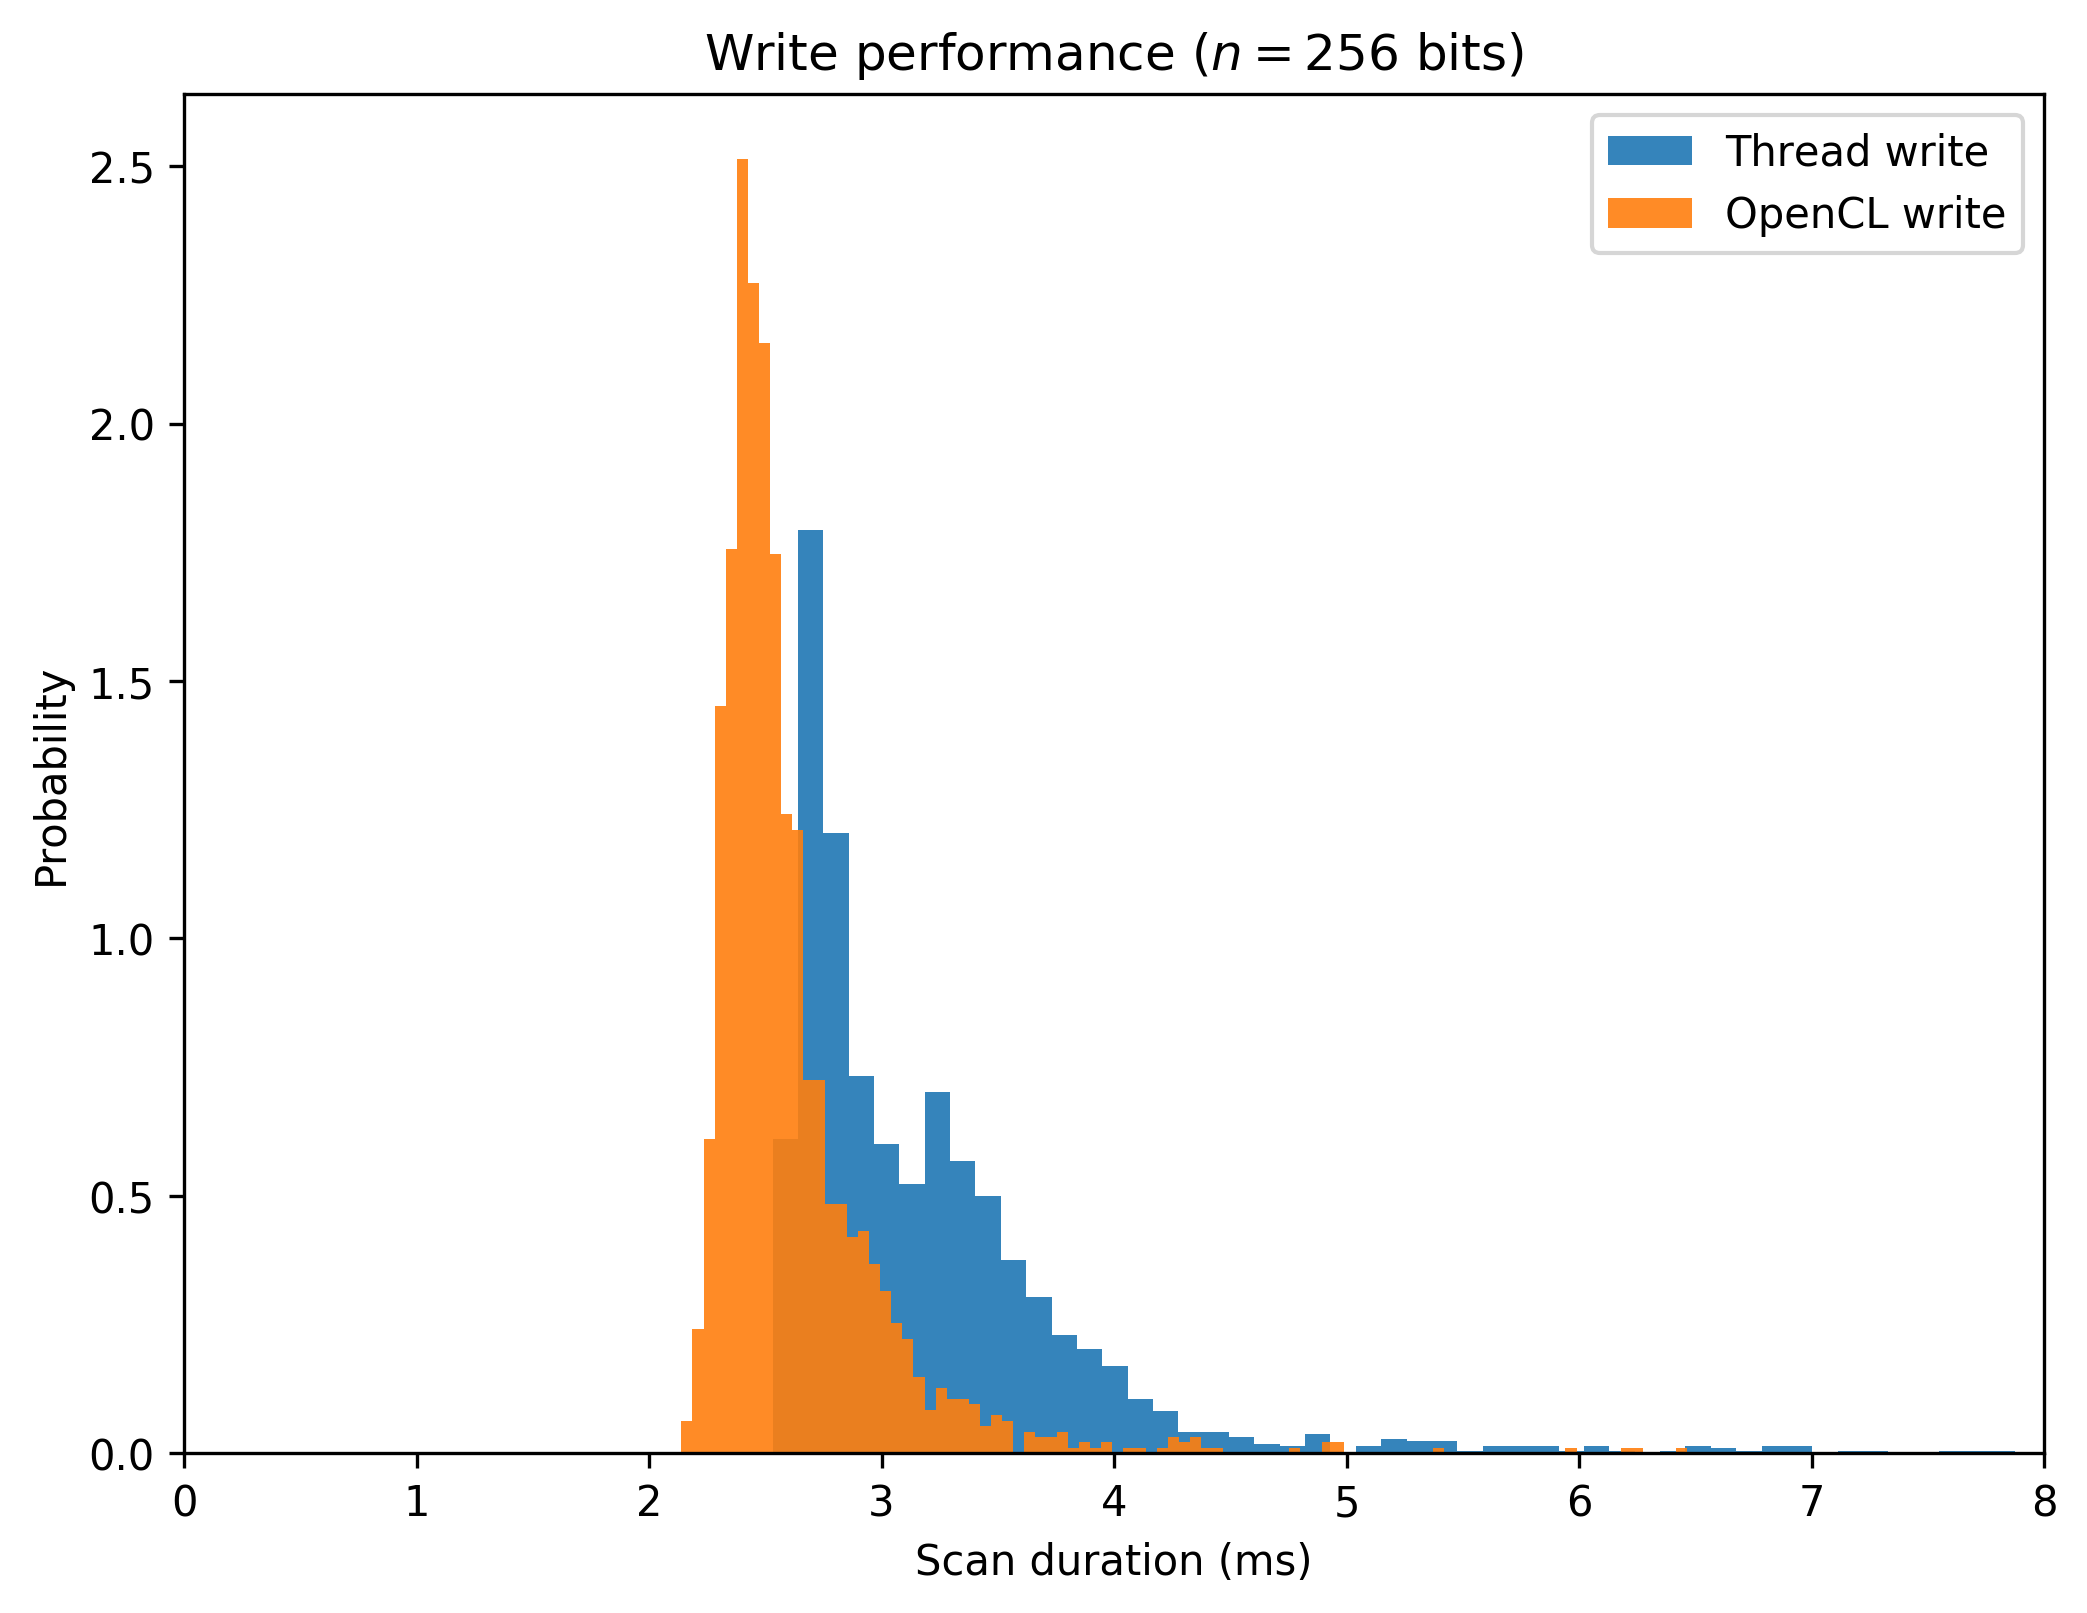

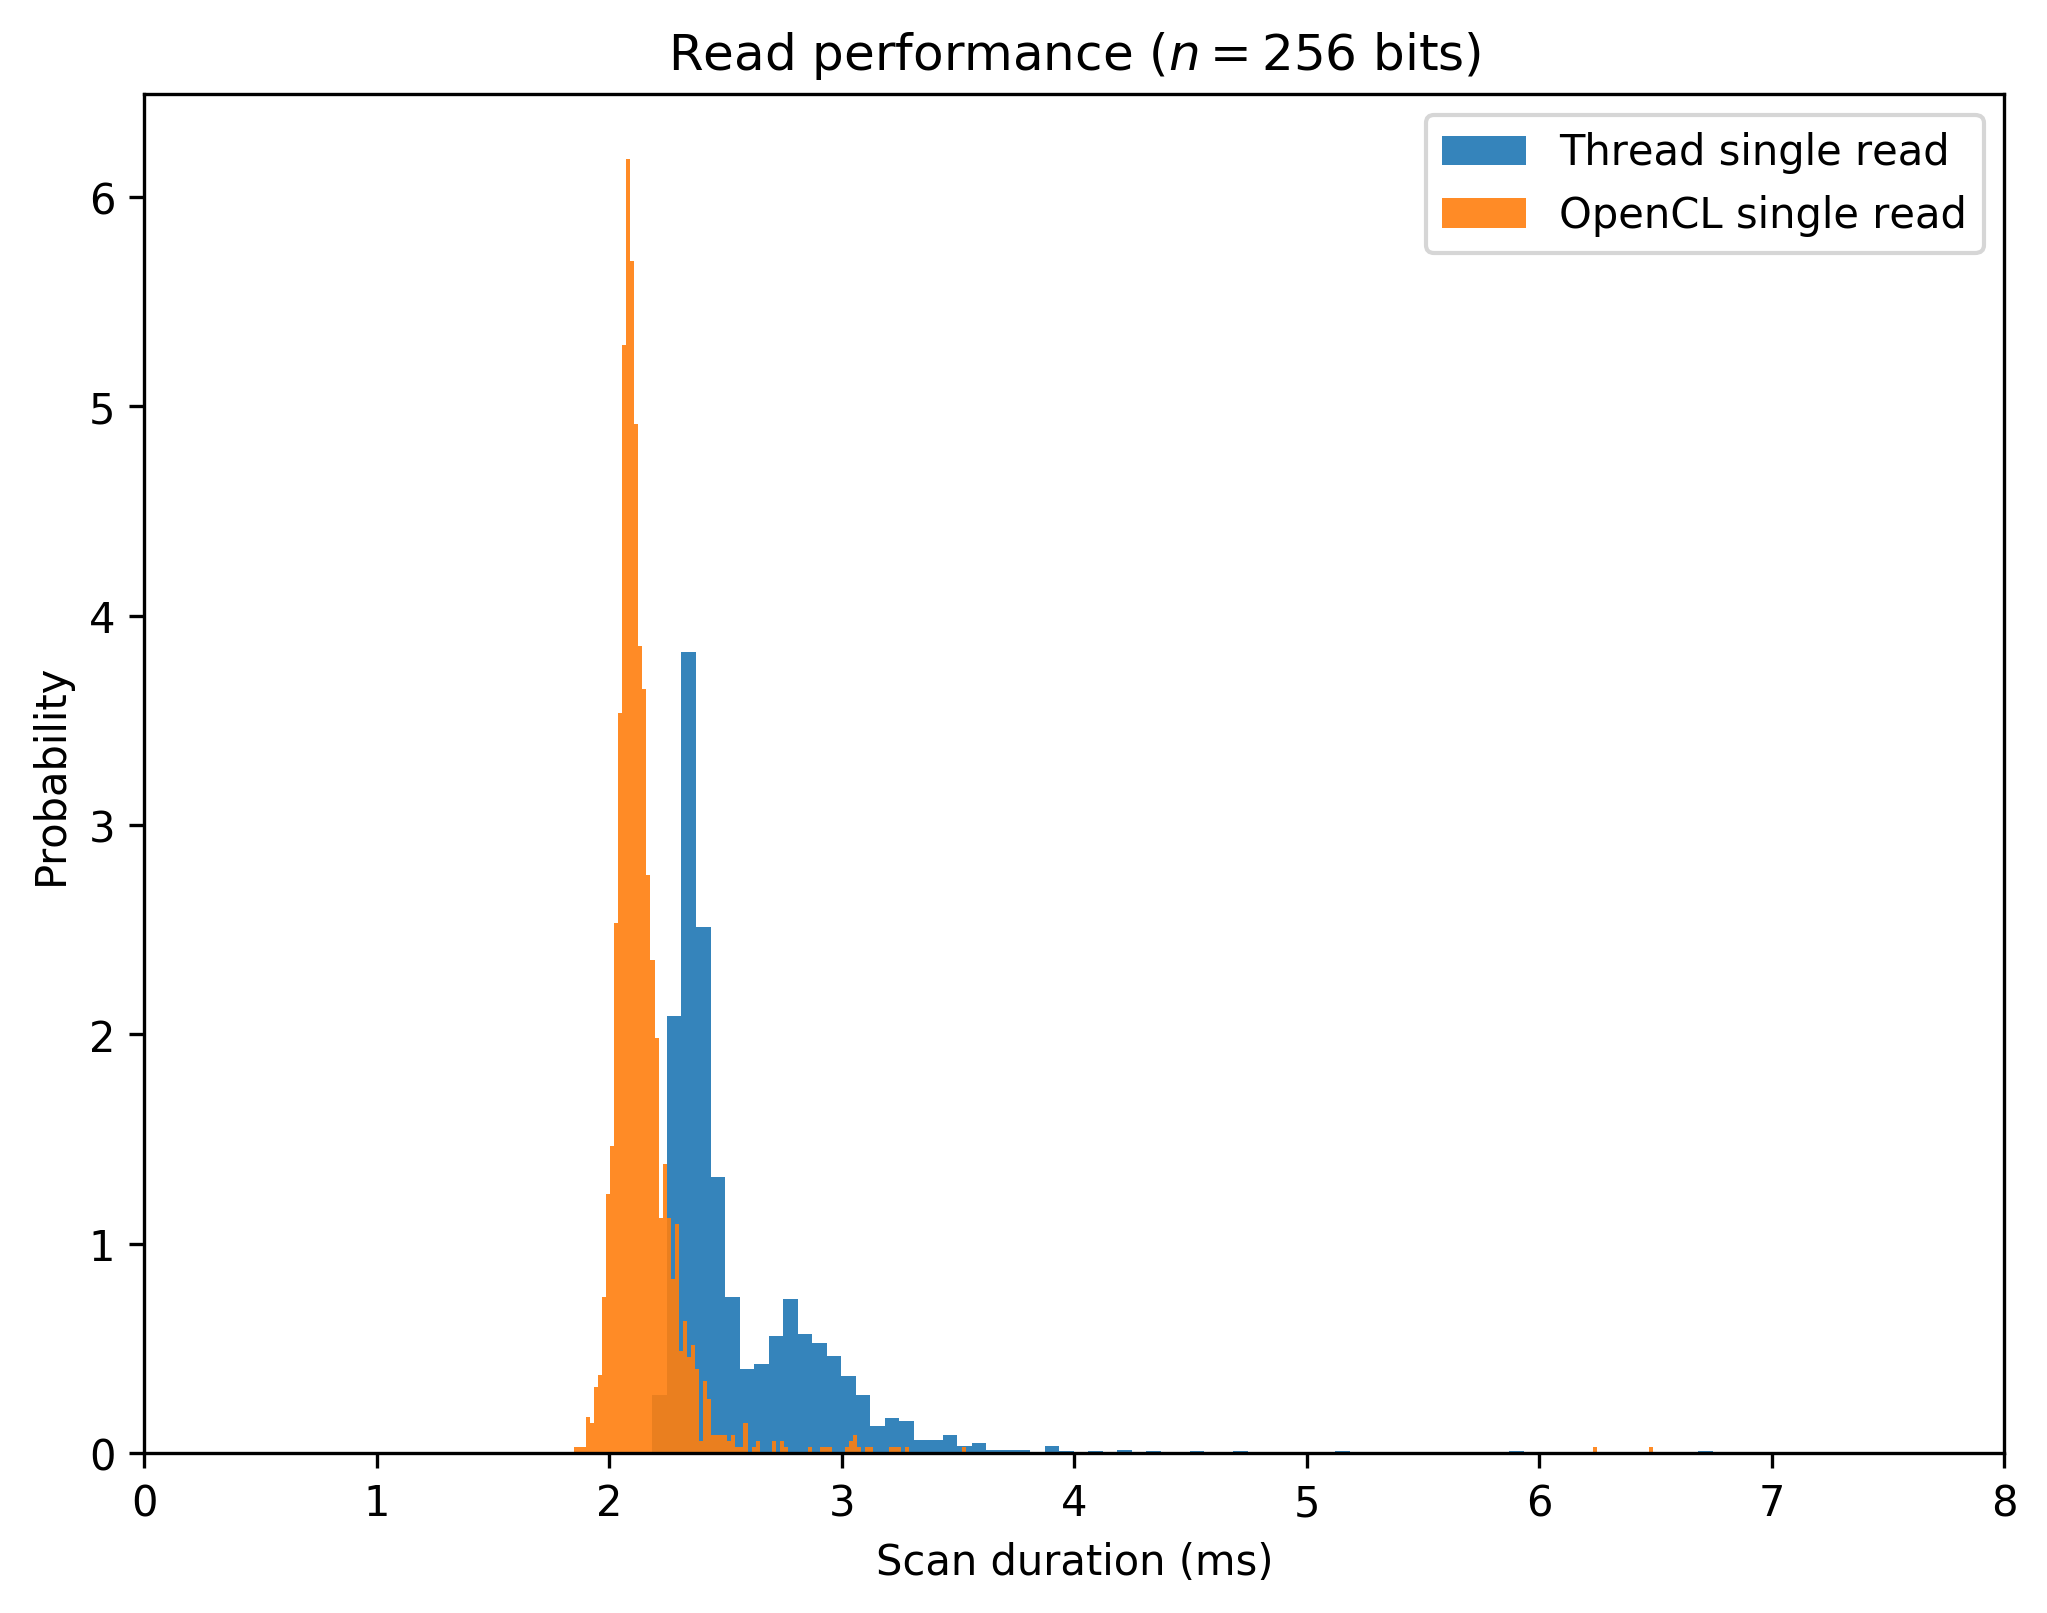

In [61]:
results_part2(256, p2timer256, hist_xlim=(0, 8))

In [ ]:
#p2timer10k = run_part2(10000, 1000000, 4845, nthread=500, nopencl=1000)

Running thread...


In [ ]:
#results_part2(10000, p2timer10k, hist1_xlim=(0, 8), hist2_xlim=(0, 8))

## Part 3 - Kernels comparison

In [57]:
def run_part3(bits, sample, radius, n=1000):
    address_space = sdmlib.AddressSpace.init_random(bits, sample)
    address_space.opencl_init()
    #address_space.opencl_opts.verbose = 1
    bs = sdmlib.Bitstring.init_random(bits)
    expected = set(address_space.scan_opencl2(bs, radius))
    
    timer = Timer()
    for kernel in sdmlib.OPENCL_KERNEL_NAMES:
        address_space.set_opencl_kernel(kernel)
        
        print('Running kernel {}...'.format(kernel))
        timer.start(kernel, kernel)
        for _ in range(n):
            address_space.scan_opencl2(bs, radius)
            timer.measure_loop()
        timer.end()
    return timer

In [70]:
def results_part3(bits, timer, hist_xlim=None):
    from IPython.display import display, Markdown
    v = [['', 'Loops', 'Total time', 'Scans per second', 'Time per scan (ms)']]
    v.append([':---', '---:', '---:', '---:', '---:'])
    for key in timer.stats.keys():
        stats = timer.stats[key]
        v.append([
            stats['name'],
            stats['number-of-loops'],
            stats['dt'],
            stats['loops-per-second'],
            1000.0 / stats['loops-per-second'],
        ])
    txt = '\n'.join(['|'.join([str(x) for x in row]) for row in v])
    display(Markdown(txt))
    
    plt.figure(figsize=(8, 6), dpi=300)
    for key in timer.stats.keys():
        stats = timer.stats[key]
        plt.hist([1000*x for x in stats['loops']], bins='fd', density=True, alpha=0.75, label=stats['name'])
    plt.legend()
    plt.title('Kernels performance ($n={}$ bits)'.format(bits))
    plt.xlabel('Scan duration (ms)')
    plt.ylabel('Probability')
    if hist_xlim:
        plt.xlim(*hist_xlim)
    plt.show()

In [58]:
p3timer1000 = run_part3(1000, 1000000, 451, n=3000)

Running kernel single_scan0...
Running kernel single_scan1...
Running kernel single_scan2...
Running kernel single_scan3...
Running kernel single_scan4...
Running kernel single_scan5...
Running kernel single_scan5_unroll...
Running kernel single_scan6...


|Loops|Total time|Scans per second|Time per scan (ms)
:---|---:|---:|---:|---:
single_scan0|3000|15.028241872787476|199.62414934459346|5.009413957595825
single_scan1|3000|11.874222040176392|252.6481305343213|3.958074013392131
single_scan2|3000|13.736932039260864|218.38937482007222|4.578977346420288
single_scan3|3000|11.063963174819946|271.1505771121497|3.687987724939982
single_scan4|3000|12.131728887557983|247.2854469305467|4.043909629185994
single_scan5|3000|11.181737899780273|268.29460920014515|3.7272459665934243
single_scan5_unroll|3000|10.841995000839233|276.7018431356759|3.6139983336130777
single_scan6|3000|12.084025859832764|248.26163356468672|4.028008619944255

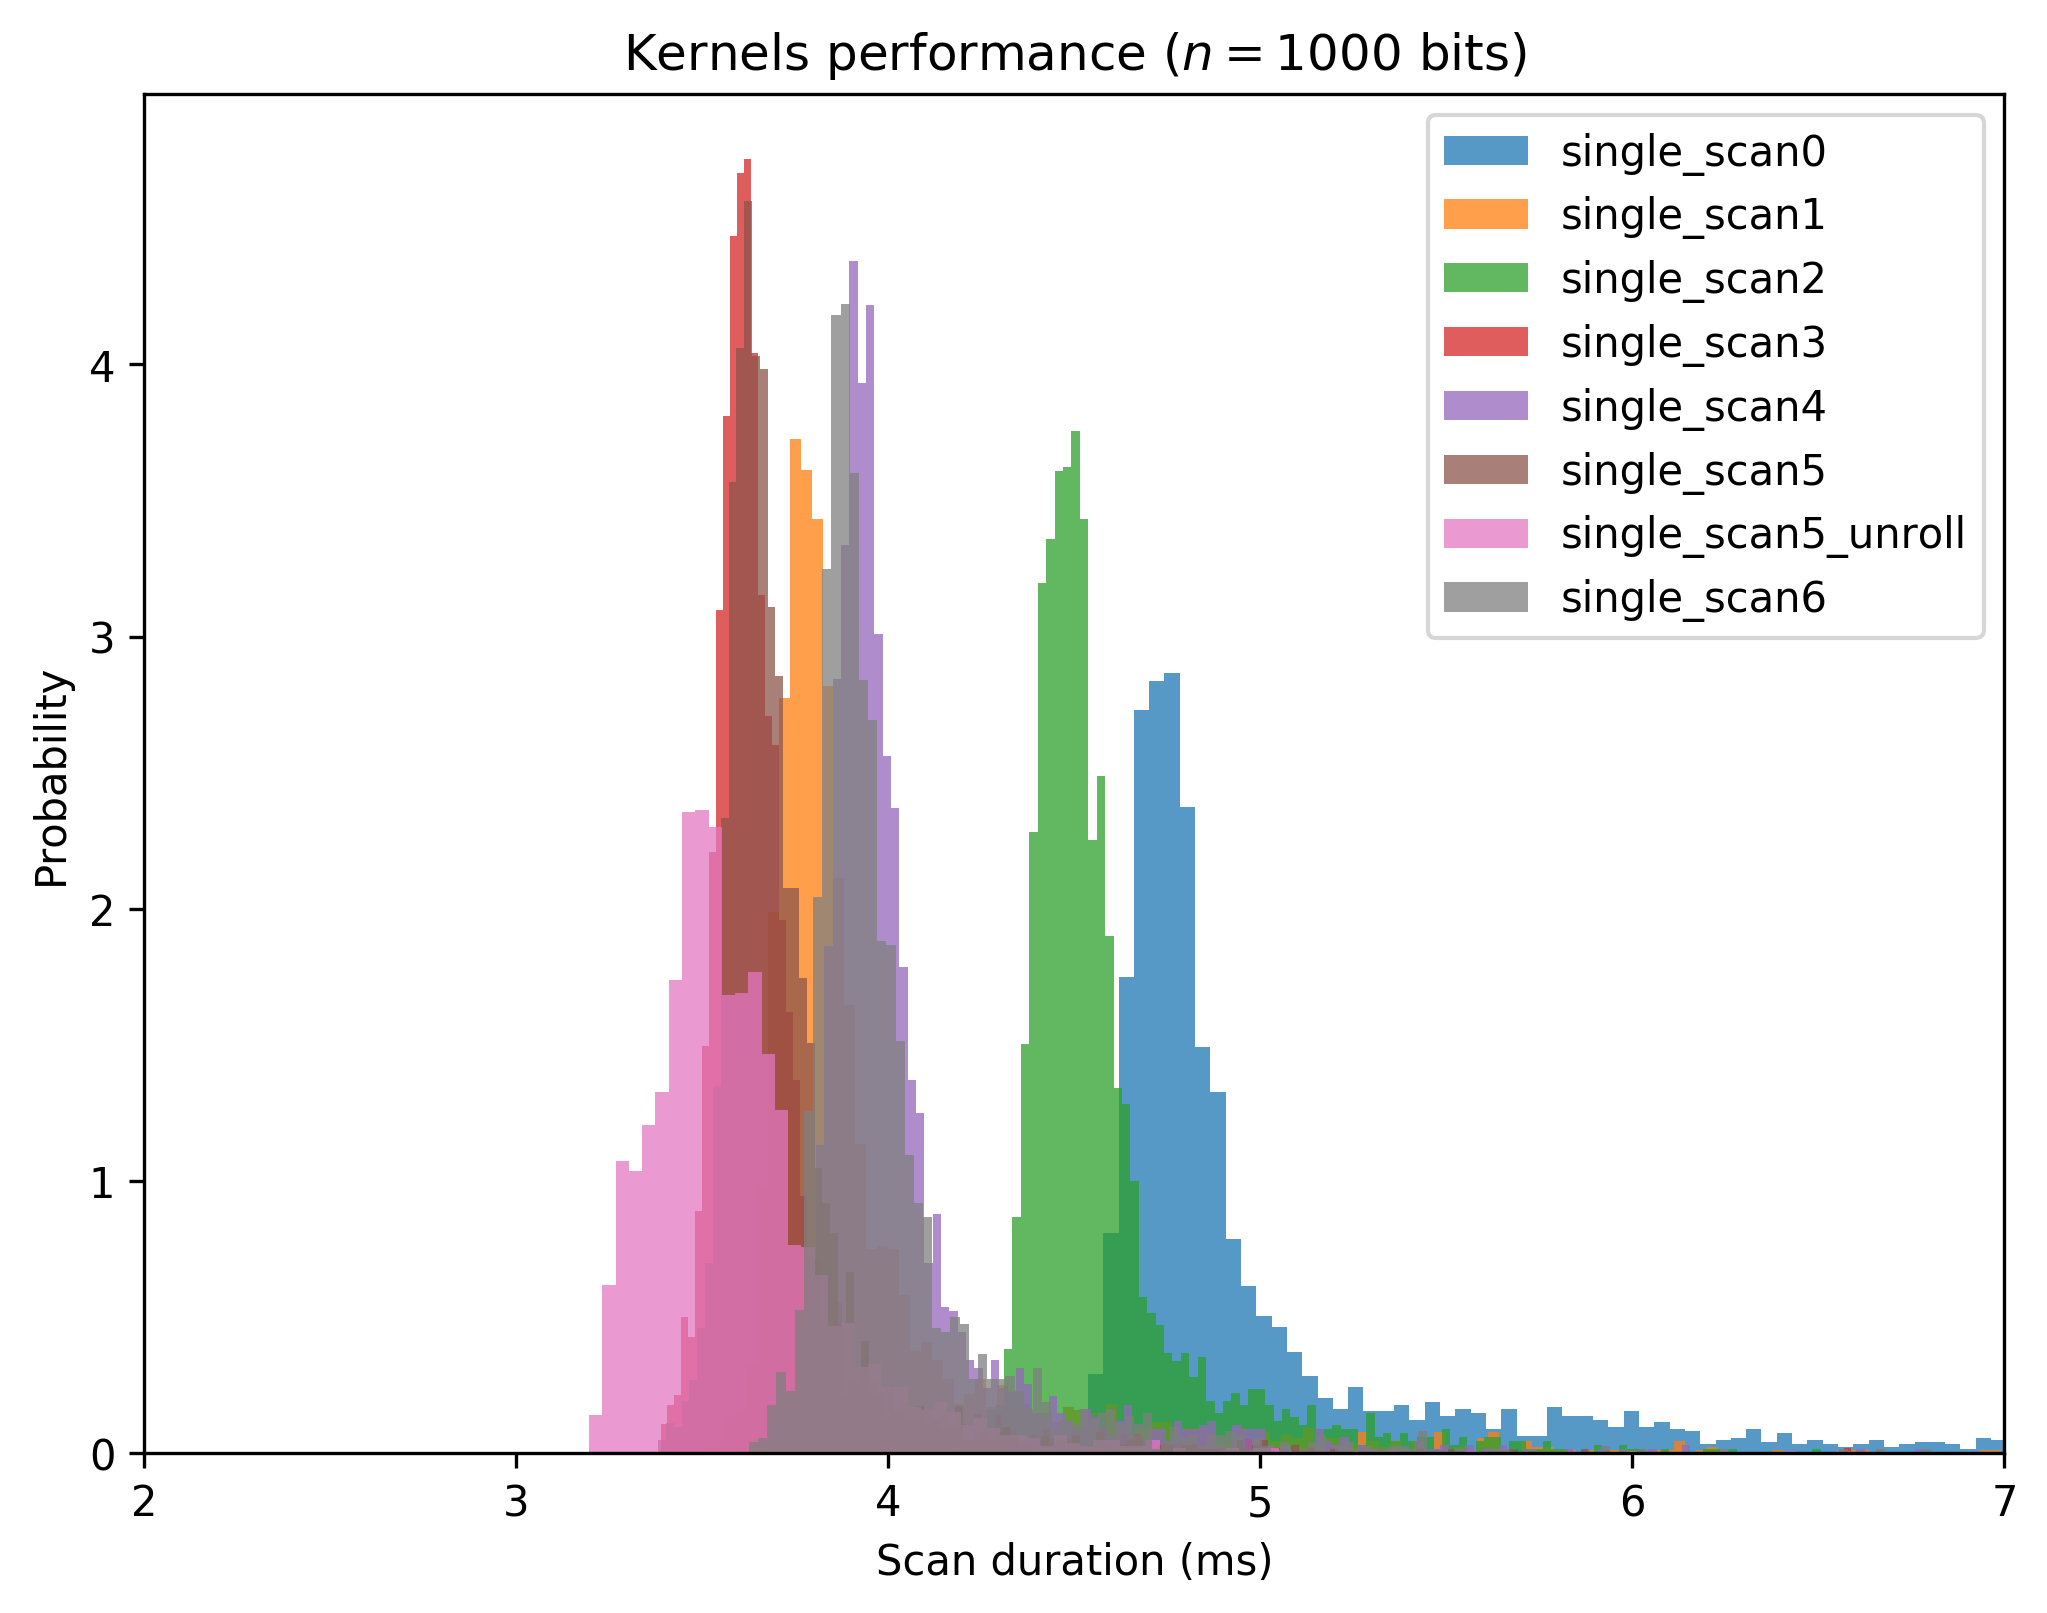

In [79]:
results_part3(1000, p3timer1000, hist_xlim=(2, 7))

In [72]:
p3timer256 = run_part3(256, 1000000, 103, n=3000)

Running kernel single_scan0...
Running kernel single_scan1...
Running kernel single_scan2...
Running kernel single_scan3...
Running kernel single_scan4...
Running kernel single_scan5...
Running kernel single_scan5_unroll...
Running kernel single_scan6...


|Loops|Total time|Scans per second|Time per scan (ms)
:---|---:|---:|---:|---:
single_scan0|3000|9.098679065704346|329.7181907764943|3.0328930219014483
single_scan1|3000|8.634926080703735|347.4262514770137|2.8783086935679116
single_scan2|3000|11.461902141571045|261.7366614149787|3.8206340471903486
single_scan3|3000|11.187175273895264|268.1642082608964|3.729058424631755
single_scan4|3000|13.442016124725342|223.18080652215394|4.480672041575114
single_scan5|3000|11.295457601547241|265.59348950936374|3.76515253384908
single_scan5_unroll|3000|11.396361827850342|263.24190520773243|3.798787275950114
single_scan6|3000|13.104900121688843|228.92200414675017|4.368300040562947

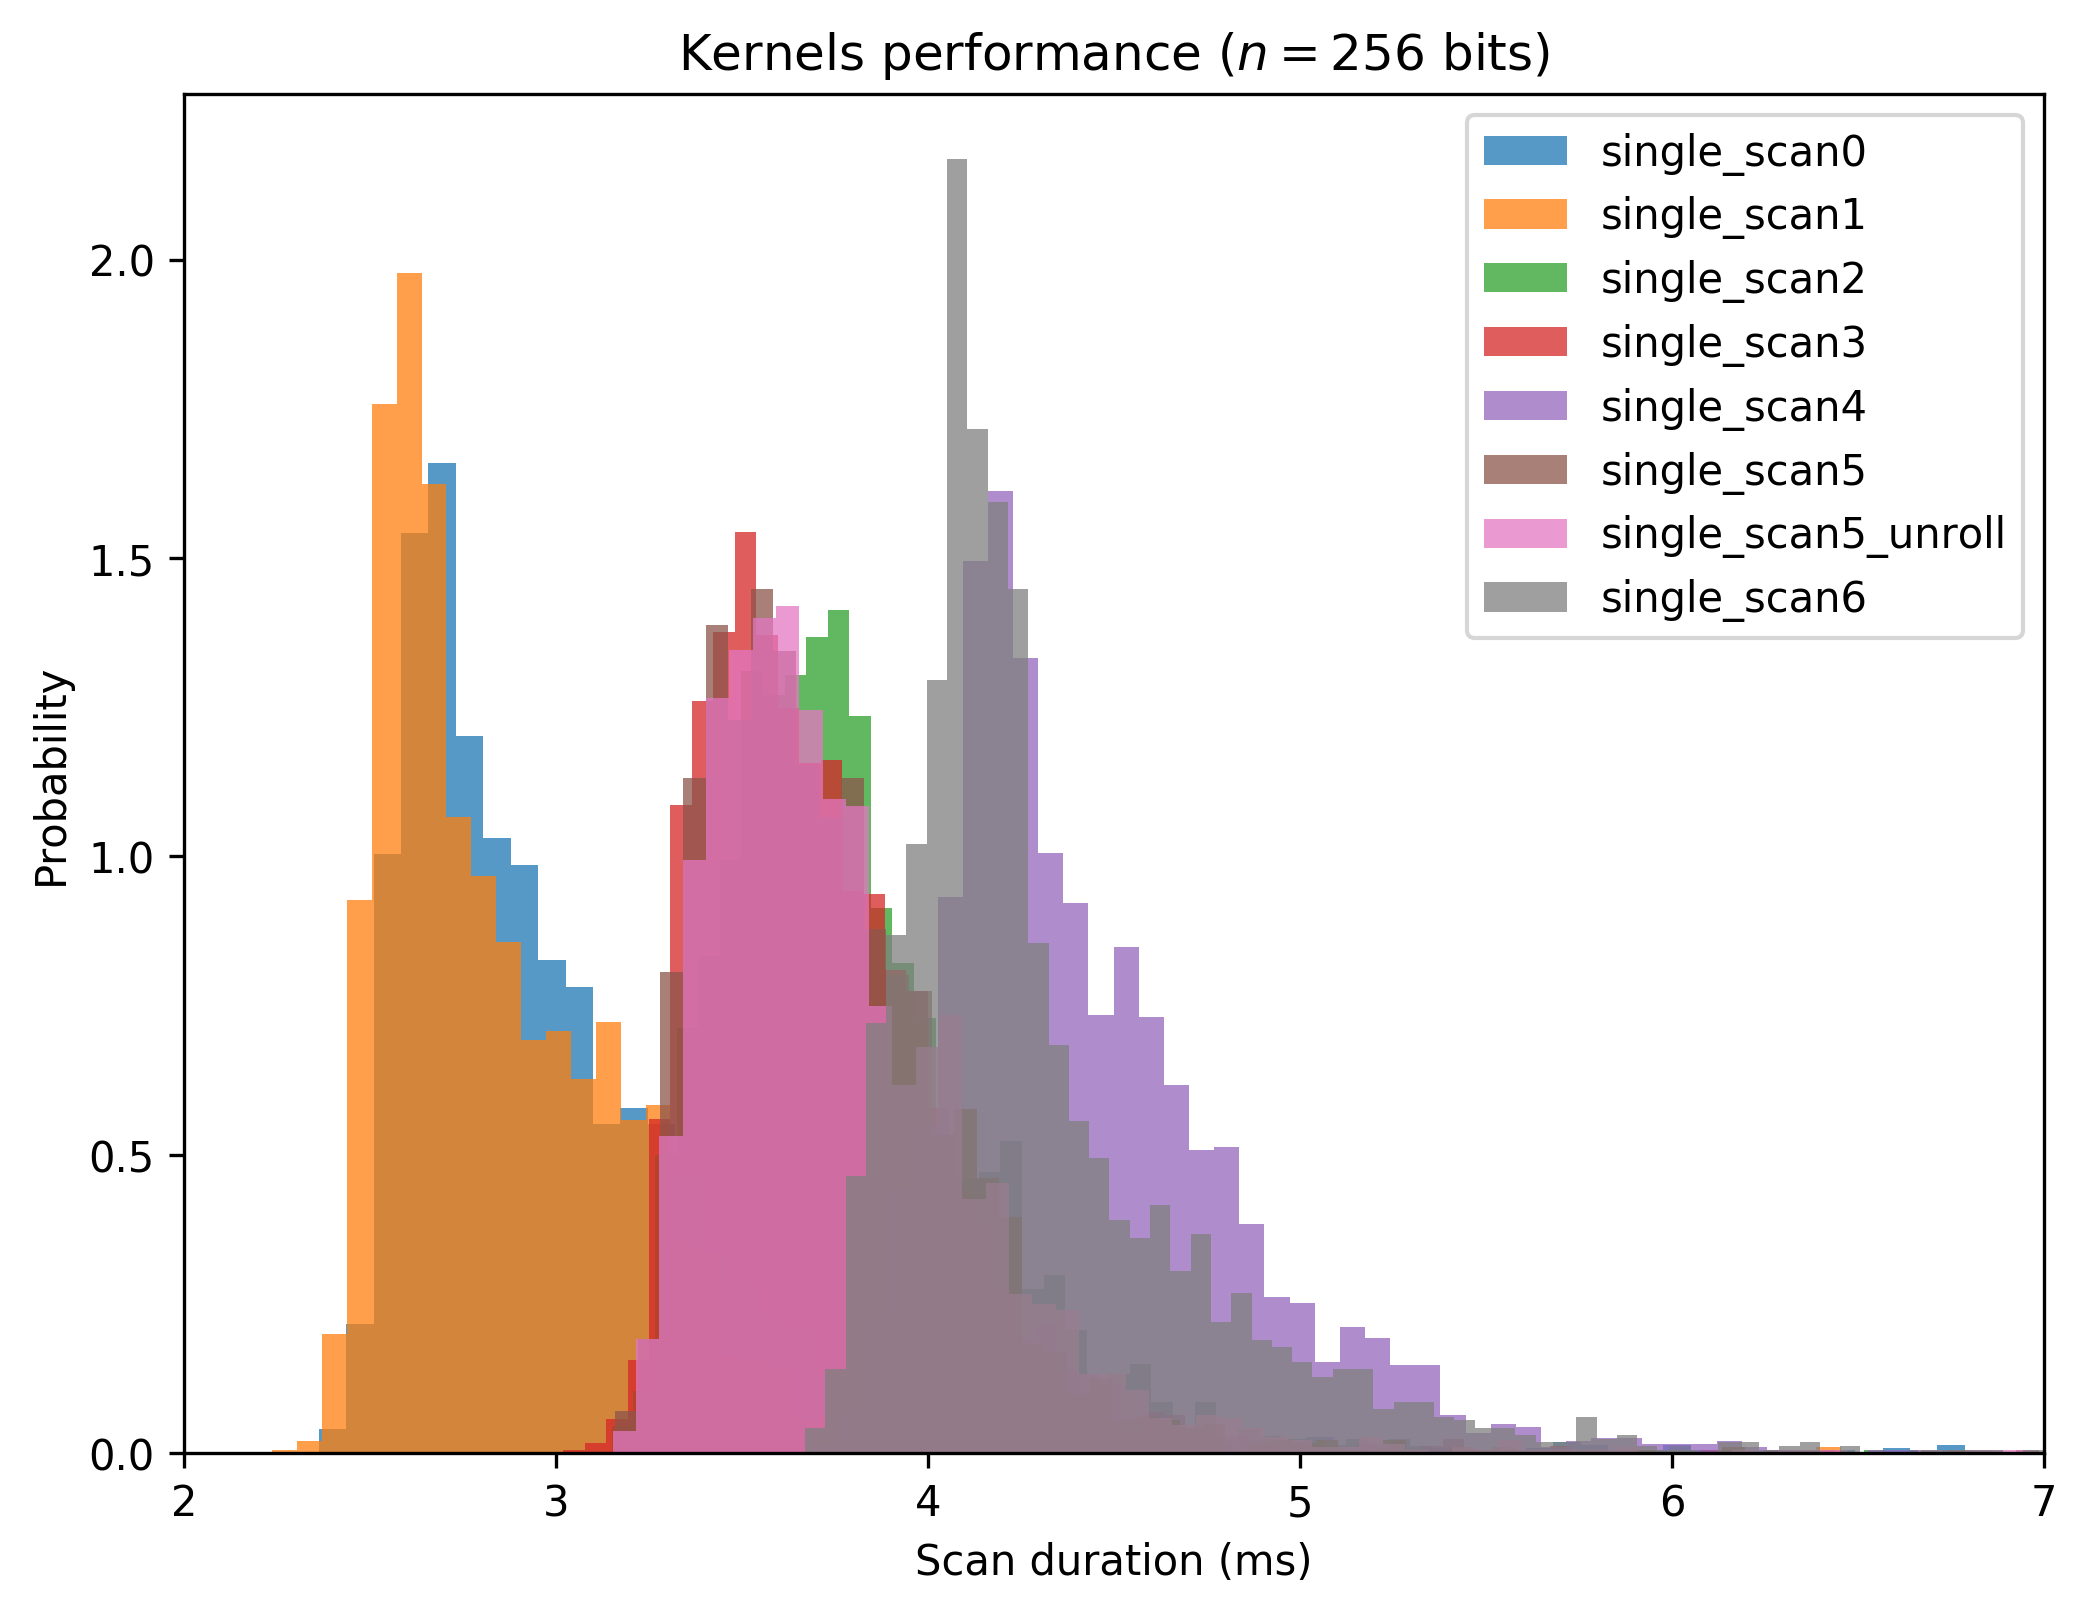

In [75]:
results_part3(256, p3timer256, hist_xlim=(2, 7))

In [76]:
p3timer10k = run_part3(10000, 1000000, 4845, n=500)

Running kernel single_scan0...
Running kernel single_scan1...
Running kernel single_scan2...
Running kernel single_scan3...
Running kernel single_scan4...
Running kernel single_scan5...
Running kernel single_scan5_unroll...
Running kernel single_scan6...


|Loops|Total time|Scans per second|Time per scan (ms)
:---|---:|---:|---:|---:
single_scan0|500|30.534967184066772|16.374669636484867|61.069934368133545
single_scan1|500|22.480546236038208|22.24145244293299|44.961092472076416
single_scan2|500|22.491918802261353|22.23020651976254|44.983837604522705
single_scan3|500|6.335015773773193|78.92640174156905|12.670031547546387
single_scan4|500|5.727261781692505|87.30175414685539|11.45452356338501
single_scan5|500|6.294461011886597|79.43491890025042|12.588922023773193
single_scan5_unroll|500|5.688975811004639|87.88928211521136|11.377951622009277
single_scan6|500|5.48170280456543|91.21253337258189|10.96340560913086

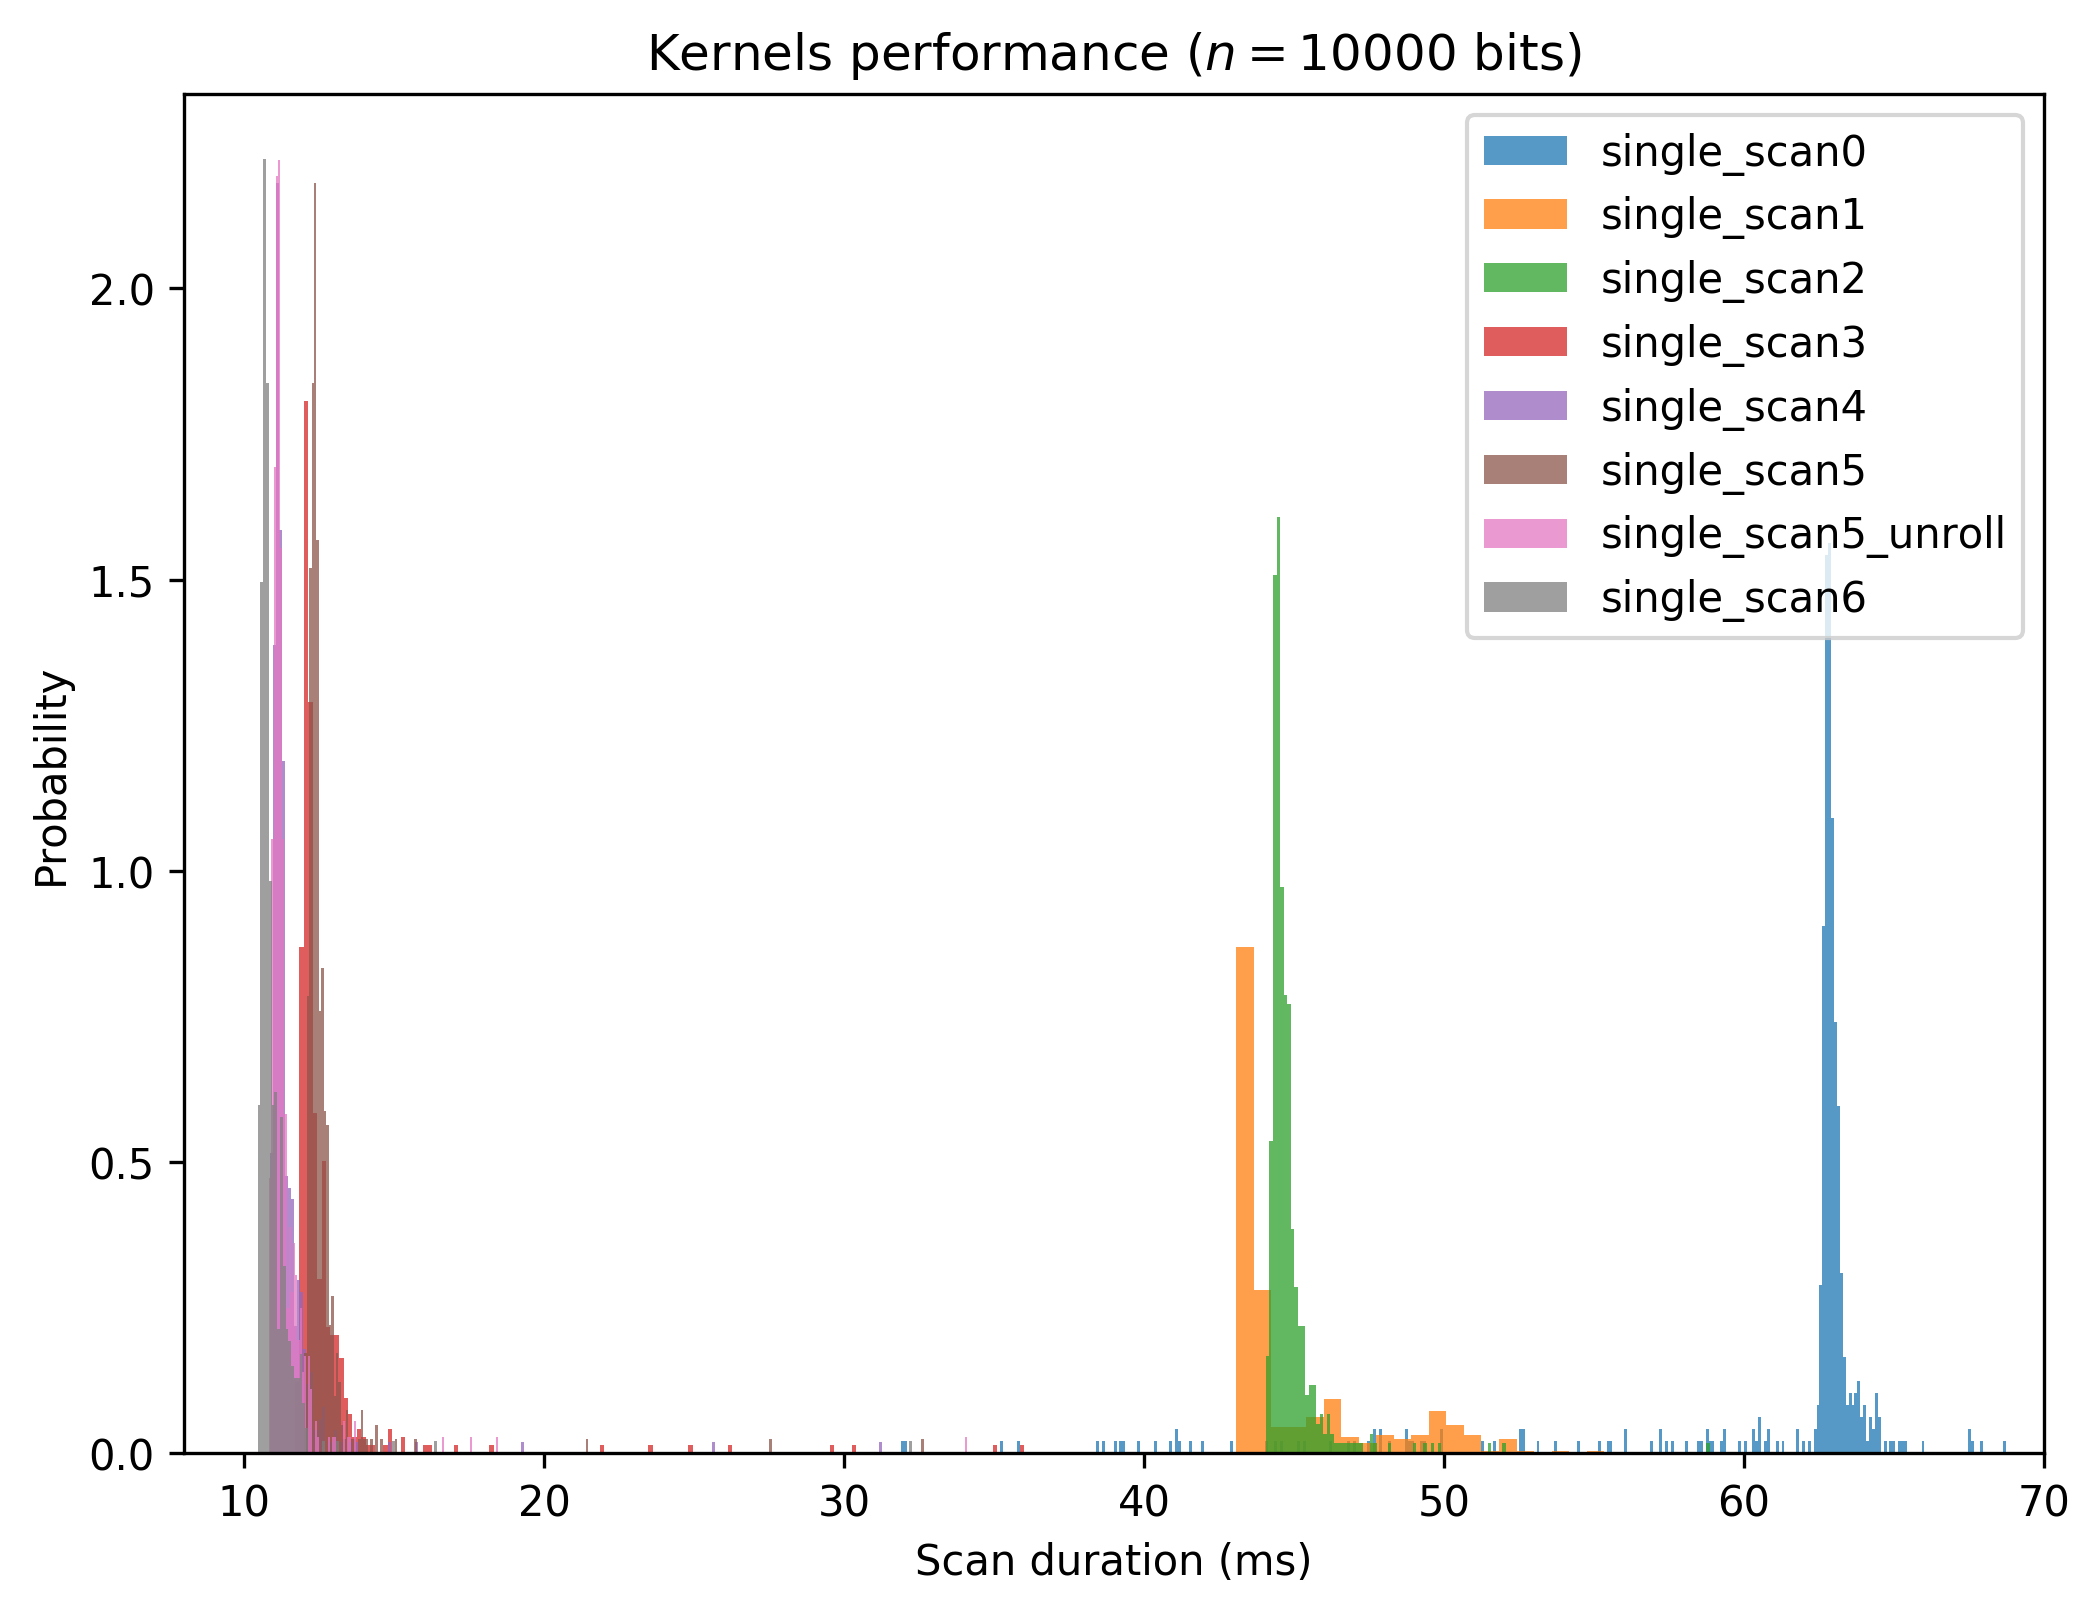

In [82]:
results_part3(10000, p3timer10k, hist_xlim=(8, 70))

|Loops|Total time|Scans per second|Time per scan (ms)
:---|---:|---:|---:|---:
single_scan0|500|30.534967184066772|16.374669636484867|61.069934368133545
single_scan1|500|22.480546236038208|22.24145244293299|44.961092472076416
single_scan2|500|22.491918802261353|22.23020651976254|44.983837604522705
single_scan3|500|6.335015773773193|78.92640174156905|12.670031547546387
single_scan4|500|5.727261781692505|87.30175414685539|11.45452356338501
single_scan5|500|6.294461011886597|79.43491890025042|12.588922023773193
single_scan5_unroll|500|5.688975811004639|87.88928211521136|11.377951622009277
single_scan6|500|5.48170280456543|91.21253337258189|10.96340560913086

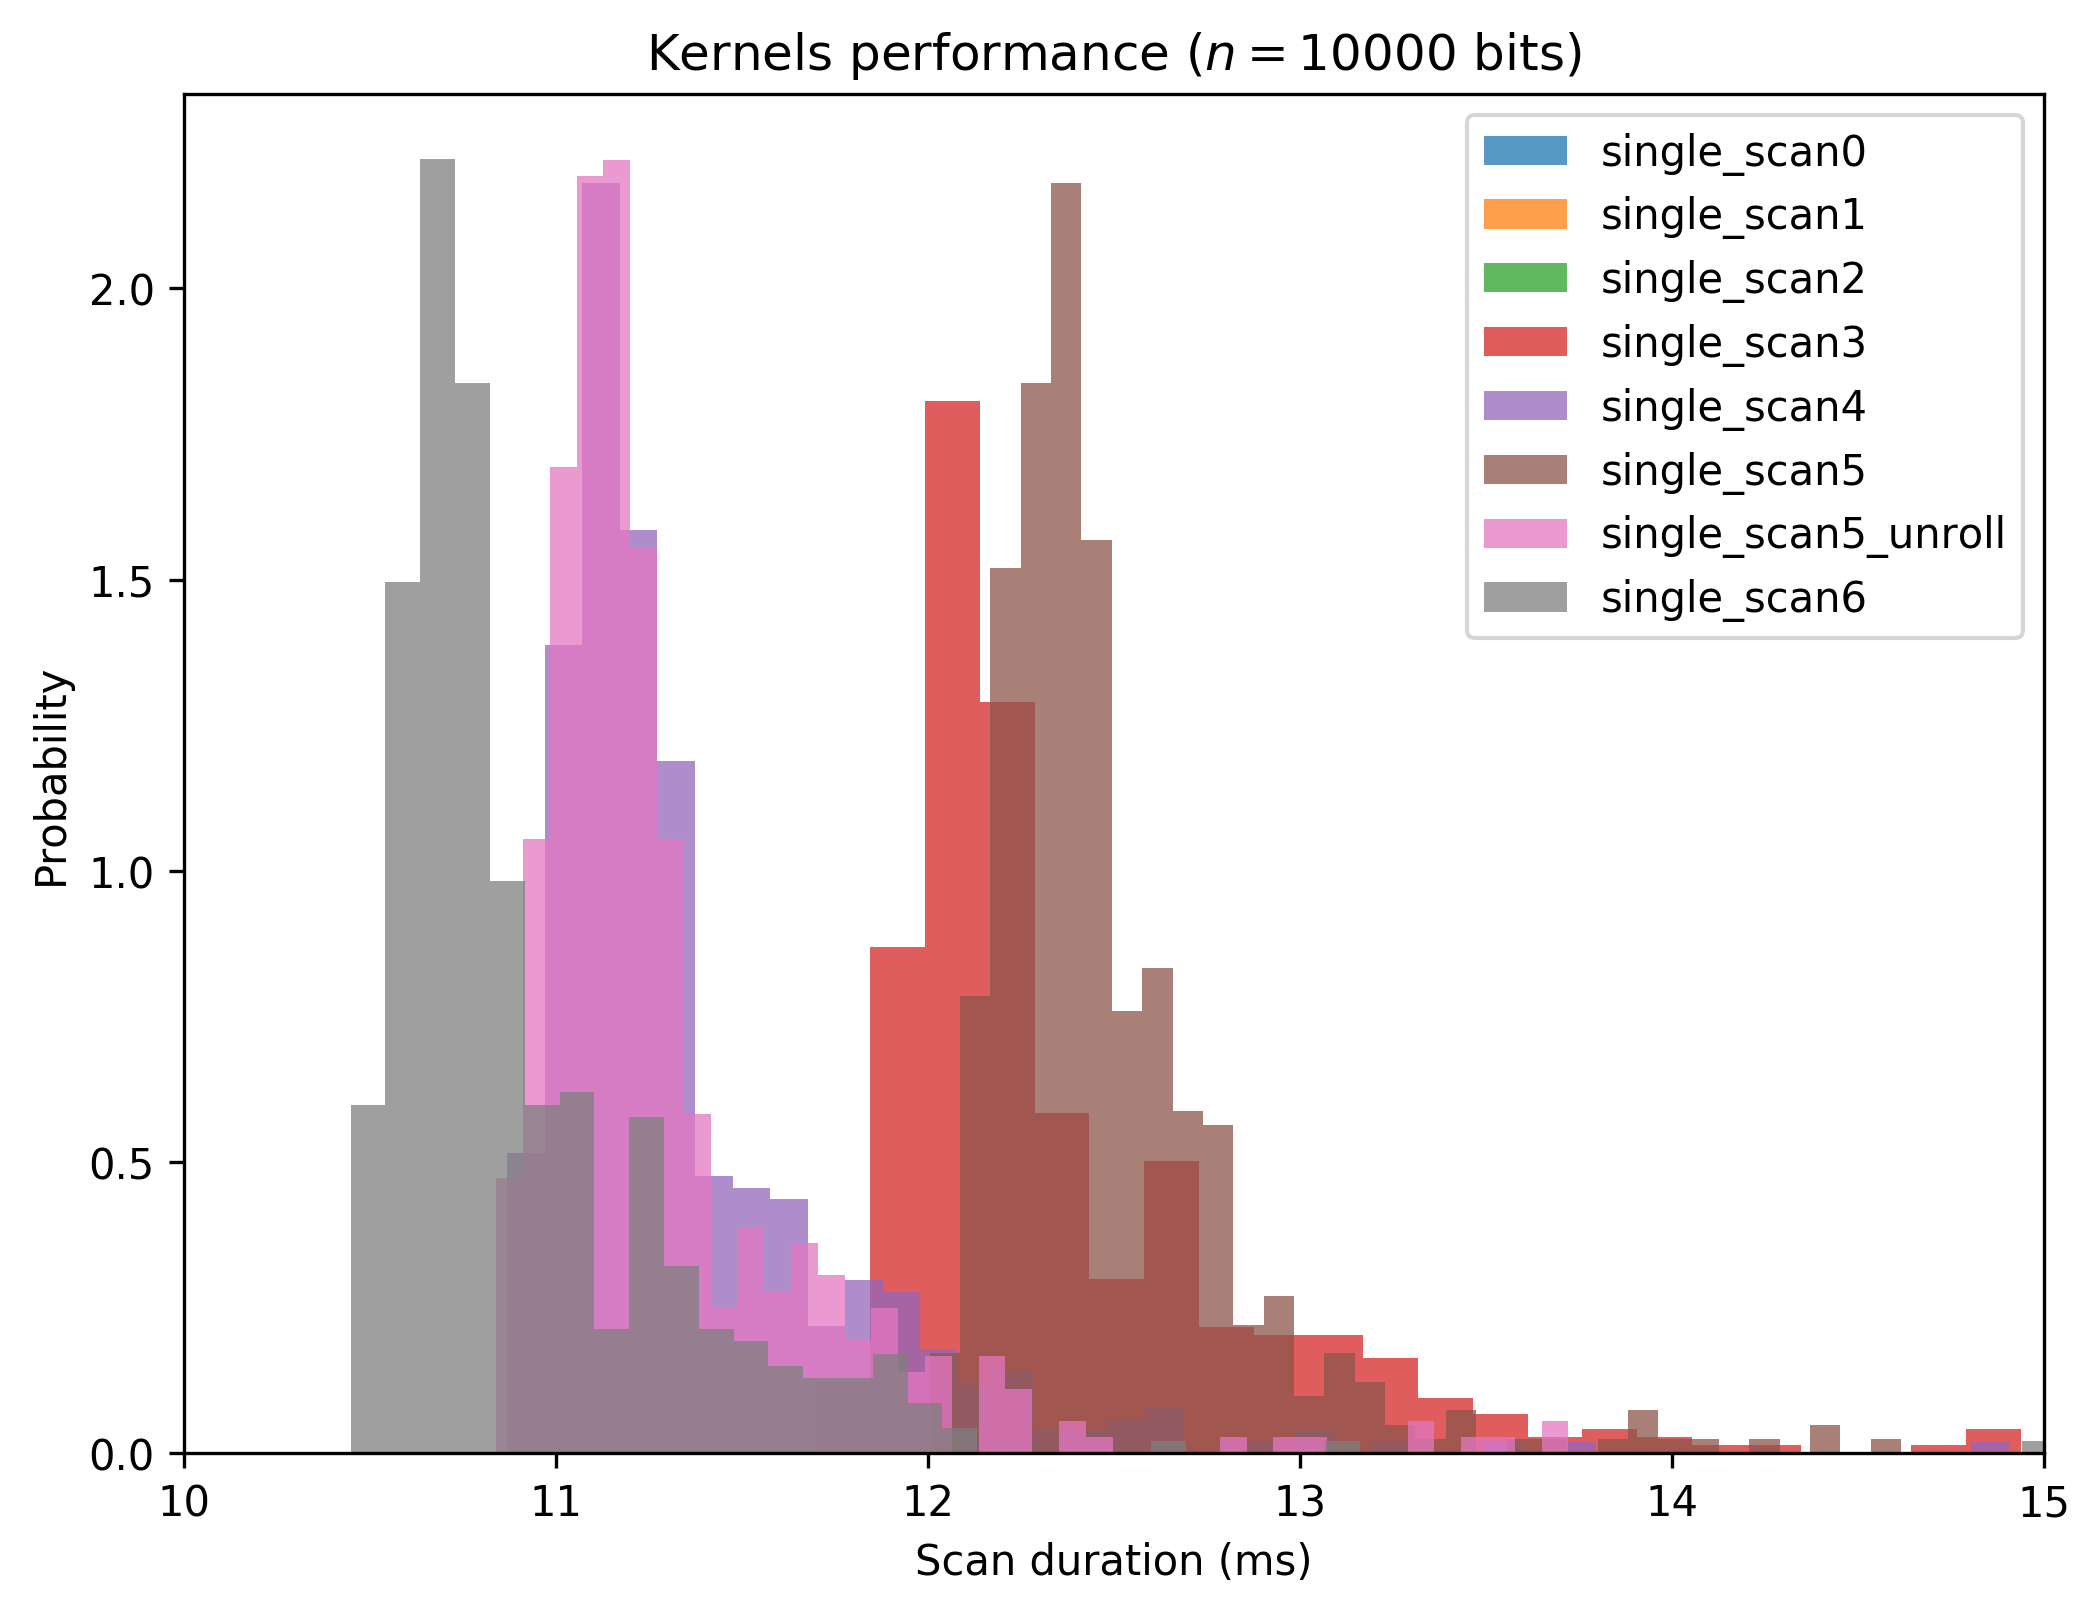

In [84]:
results_part3(10000, p3timer10k, hist_xlim=(10, 15))